In [ ]:
%load_ext autoreload
%autoreload 2
# default_exp indexers.faceclustering.indexer

In [ ]:
# export
from integrators.indexers.facerecognition.model import *
from integrators.indexers.faceclustering.models import *
from integrators.indexers.faceclustering.utils import *
from integrators.data.basic import *
from integrators.data.schema import *
from integrators.imports import *
from integrators.indexers.facerecognition.photo import *
from integrators.indexers.indexer import *
from integrators.pod.client import PodClient, DEFAULT_POD_ADDRESS

In [ ]:
# export
from fastprogress.fastprogress import progress_bar
from mmcv.runner import load_checkpoint
from collections import Counter
import cv2
import ipdb
import torch

# Face Clustering 

This module contains functionality to cluster faces on images by person. It uses the `FaceRecognitionModel` to extract faces from photos, crop them and create embeddings for each face. These are embeddings are used as input for this module to cluster them based on network topology generated by the the graph of all embeddings.

In [ ]:
# export
class FaceClusteringIndexer(IndexerBase):
    """Clusters faces on photos."""
    model_fname = "pretrained_gcn_v_ms1m.pth"
    model_path = MODEL_DIR / model_fname
    model_s3_url = f"{MEMRI_S3}/{model_fname}"
    
    def __init__(self, *args, **kwargs):
        self.rec_model = FaceRecognitionModel()
        self.model = GCN_V(feature_dim=256, nhid=512, nclass=1, dropout=0.0)
        download_file(self.model_s3_url, self.model_path)
        load_checkpoint(self.model, str(self.model_path), map_location="cpu", strict=True);
        self.model.eval()
        super().__init__(*args, **kwargs)
        
    def get_data(self, client, indexer_run):
        photos = [d.expand(client) for d in get_indexer_run_data(client, indexer_run)]
        for p in photos: client._load_photo_data(p, size=640)
        photos = [p for p in photos if p.data is not None]
        return IndexerData(photos=photos)
        
    def get_clusters(self, pred_confs, dataset):
        pred_dist2peak, pred_peaks = confidence_to_peaks(dataset.dists, dataset.nbrs,pred_confs, max_conn=1)
        pred_labels = peaks_to_labels(pred_peaks, pred_dist2peak, tau=0.4, inst_num=dataset.inst_num)
        # original tau: 0.65
        return pred_labels

    def get_predictions(self, features):
        dataset = GCNVDataset(features)
        features = torch.FloatTensor(dataset.features)
        adj = sparse_mx_to_torch_sparse_tensor(dataset.adj)
        pred_confs, _ = self.model((features, adj), output_feat=True)
        clusters = self.get_clusters(pred_confs.detach().numpy(), dataset)
        return clusters
    
    def create_cluster_items(self, crop_photos, pred_labels, min_cluster_size=2):
        c2p = {c: Person(firstName="unknown person") for c in set(pred_labels)
               if list(pred_labels).count(c) >= min_cluster_size }
        
        for photo, clust in zip(crop_photos, pred_labels):
            if clust in c2p:
                person = c2p[clust]
                person.add_edge("occurence", photo)
        people = list(c2p.values())
        return people
    
    def get_crops(self, photos):
        return self.rec_model.get_crops(photos)
    
    def index(self, data, *args, **kwargs):
        photos = data.photos
        print(f"Indexing {len(photos)} photos")
        crop_photos = self.get_crops(photos)
        files = [c.file[0] for c in crop_photos]
        for c in progress_bar(crop_photos): c.embedding = self.rec_model.get_embedding(c)
        features = np.stack([x.embedding[256:] for x in crop_photos])
        pred_labels = self.get_predictions(features)
        people = self.create_cluster_items(crop_photos, pred_labels)
        return crop_photos + people + files

In [ ]:
test_registration(FaceClusteringIndexer)

# Cluster

## Toy dataset

You can test the model on your favorite images, we use 2 images from the modern family tv show as input

In [ ]:
data_dir = PYI_TESTDATA / "photos" / "faceclustering"
photos   = [IPhoto.from_path(path=x, size=640) for x in data_dir.ls() if str(x).endswith("jpg")]
data = IndexerData(photos=photos)

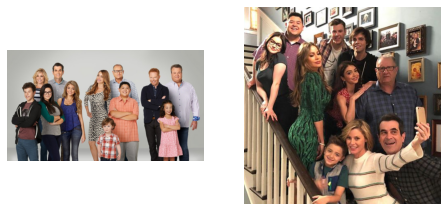

In [ ]:
show_images(photos)

## Run the model

As per usual, you can run the indexer by calling indexer.index(), in this example we are doing that on our example images.

In [ ]:
cluster_indexer = FaceClusteringIndexer()

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [ ]:
items = cluster_indexer.index(data)

Indexing 2 photos


This generates a few data items for you, from various types. It creates photos and their files, which correspond to the crops of the faces and it creates Person items for the people in the crops. 

In [ ]:
set([type(i) for i in items])

{integrators.data.schema.File,
 integrators.data.schema.Person,
 integrators.indexers.facerecognition.photo.IPhoto}

## Show the result

The Person and Photo items are connected with an edge, called "occurence", you can inspect them as follows:

In [ ]:
people = [x for x in items if isinstance(x, Person) and len(x.occurence) >=1]
print(len(people))

7


Cluster


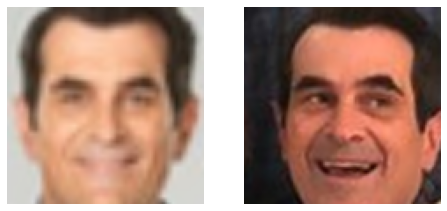

Cluster


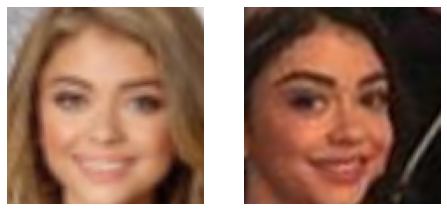

In [ ]:
for p in people[2:4]:
    print("Cluster")
    show_images([p.data for p in p.occurence])

## Simluate run from pod

You can also test the full pipelines as if you are running it from the pod. You can do that as follows.

In [ ]:
# hide
# TODO: move this to separate file

In [ ]:
client = PodClient()

In [ ]:
photos = [IPhoto.from_path(path=x, size=640) for x in data_dir.ls() if str(x).endswith("jpg")]
indexer = Indexer.from_data(indexerClass="FaceClusteringIndexer", name="FaceClustering")
indexer_run = IndexerRun.from_data(progress=0, targetDataType="Photo")

for x in [indexer, indexer_run] + photos : client.create(x)
assert client.create_edge(Edge(indexer_run, indexer, "indexer"))

In [ ]:
# hide_output
run_integrator(pod_full_address=DEFAULT_POD_ADDRESS,
               integrator_run_uid=indexer_run.uid,
               database_key=client.database_key,
               owner_key=client.owner_key)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
Indexing 2 photos


creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating Person (#None)
creating Person (#None)
creating Person (#None)
creating Person (#None)
creating Person (#None)
creating Person (#None)
creating Person (#None)
updating File (#7)
updating File (#9)
updating File (#11)
updating File (#13)
updating File (#15)
updating File (#17)
updating File (#19)
updating File (#21)
updating File (#23)
updating File (#25)
updating File (#27)
updating File (#29)
updating File (#31)
updating File (#33)
updating File (#35)
updati

In [ ]:
client.delete_all()

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted basic.ipynb.
Converted importers.EmailImporter.ipynb.
Converted importers.Importer.ipynb.
Converted importers.util.ipynb.
Converted index.ipynb.
Converted indexers.FaceClusteringIndexer.Models.ipynb.
Converted indexers.FaceClusteringIndexer.Utils.ipynb.
Converted indexers.FaceClusteringIndexer.indexer.ipynb.
Converted indexers.FaceRecognitionModel.ipynb.
Converted indexers.FacerecognitionIndexer.Photo.ipynb.
Converted indexers.GeoIndexer.ipynb.
Converted indexers.NoteListIndexer.NoteList.ipynb.
Converted indexers.NoteListIndexer.Parser.ipynb.
Converted indexers.NoteListIndexer.ipynb.
Converted indexers.NoteListIndexer.util.ipynb.
Converted indexers.indexer.ipynb.
Converted itembase.ipynb.
Converted pod.client.ipynb.
